In [1]:
# Import Libraries
import sys, os
from tqdm import tqdm, trange

import random
import numpy as np
import pandas as pd
from numba import njit
import scipy
import pickle

from IPython.display import clear_output
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.epochs import EpochAnimation
import data_analysis.visualization.publication as publication
from activations import get_activations

import models as models
from models import MLP
import simulate


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")
device = torch.device("cpu")

plot_path = "/home/loek/projects/rnn/DNN/plots/mnist/"

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


GPU available


In [2]:
# Load the data
encoding = Direct()
input_size = 28 * 28
output_size = 10

input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(torch.ravel),
        transforms.Lambda(lambda x: x.to(device)),
    ]
)
output_transforms = transforms.Lambda(
    lambda y: torch.zeros(10, dtype=torch.float)
    .scatter_(0, torch.tensor(y), value=1)
    .to(device)
)

train_data = datasets.MNIST(
    "./DNN/data/MNIST",
    train=True,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)
val_data = datasets.MNIST(
    "./DNN/data/MNIST",
    train=False,
    download=True,
    transform=input_transforms,
    target_transform=output_transforms,
)

train_datasets = [torch.utils.data.Subset(train_data, np.arange(60000))]
tracked_datasets = [val_data] + train_datasets

analyzed_data = torch.utils.data.Subset(train_data, np.arange(100))
labels = np.array([np.argmax(y.cpu()) for x, y in analyzed_data])
analyzed_data = torch.utils.data.Subset(train_data, np.argsort(labels))
labels = labels[np.argsort(labels)]

In [3]:
## Load settings
settings = "low_init"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/mnist.txt", sep=" ", header=0).loc[settings].to_numpy()
)
model_type = getattr(models, model_type)
nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [5]:
def single_trial():
    ## Instantiate model
    model = model_type(
        encoding=encoding,
        input_size=input_size,
        output_size=output_size,
        hidden_dim=P,
        n_hid_layers=L,
        device=device,
        init_std=gain,
    )

    ## Setup compiler
    criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {}

    ## Training run
    compiler.training_run(
        train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=64
    )

    ## Collect activations
    hid_act = get_activations(
        [analyzed_data], lambda x: model(x)[1][int(L / 2)], encoding
    )
    h = hid_act.to_numpy()
    dist2_h = np.array([[np.linalg.norm(h_1 - h_2) ** 2 for h_1 in h] for h_2 in h])

    return dist2_h

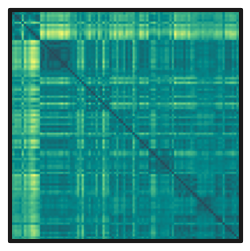

Training:   0%|          | 0/1 [00:00<?, ?steps/s]

In [6]:
data_path = f"plots/mnist/structure/data.pkl"
if os.path.exists(data_path):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
else:
    data = []

publication.set_color_gradient(2)
for _ in range(10):
    dist2_h = single_trial()
    data.append(dist2_h)
    with open(data_path, "wb") as f:
        pickle.dump(data, f)

    dist2_h_av = sum(data) / len(data)
    clear_output(wait=True)
    fig = plt.figure(figsize=(3, 3))
    plt.imshow(dist2_h_av)
    publication.im_show(colorbar=False, save_path="plots/mnist/structure/experiment")